In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import os
from segpy.reader import create_reader

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
mat = scipy.io.loadmat(r'C:\Users\user\Desktop\seismic\Book_Seismic_Data')

In [6]:
dataset = []

directory = r'C:\Users\user\Desktop\2D\Correlated_Shot_Gathers'

for file_name in os.listdir(directory):
    
    if file_name != ".segpy":
        
        with open(directory + "\\" + file_name, 'rb') as segy_in_file:

            seg_y_dataset = create_reader(segy_in_file, endian='<')

            for i in seg_y_dataset.trace_indexes():
                dataset.append(seg_y_dataset.trace_samples(i)[:-1])
            
dataset = np.array(dataset)

In [7]:
max_dataset = np.max(dataset, axis = 1)
min_dataset = np.min(dataset, axis = 1)

In [8]:
dataset = (dataset - np.repeat(np.expand_dims(min_dataset,axis = 1), 4000, axis = 1))/(np.repeat(np.expand_dims(max_dataset,axis = 1), 4000, axis = 1) - np.repeat(np.expand_dims(min_dataset,axis = 1), 4000, axis = 1))

In [9]:
def get_metrics(x,x_pred):
    nmse = np.sum(np.square(x - x_pred))/np.sum(np.square(x))
    nrmse = np.sqrt(np.mean(np.square(x - x_pred)))/(np.amax(x) - np.amin(x))
    snr = -10*np.log10(nmse)
    return nmse, nrmse, snr

CR 100:1

In [19]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(8, 3, activation='elu', padding="same", input_shape=[4000,1]),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(16, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(8, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [20]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [21]:
history = model.fit(np.expand_dims(dataset[:900],axis = 2),np.expand_dims(dataset[:900],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 11s 122ms/step - loss: 0.0178
Epoch 2/30
90/90 [==============================] - 11s 121ms/step - loss: 0.0100
Epoch 3/30
90/90 [==============================] - 11s 125ms/step - loss: 0.0096
Epoch 4/30
90/90 [==============================] - 12s 128ms/step - loss: 0.0093
Epoch 5/30
90/90 [==============================] - 11s 122ms/step - loss: 0.0090
Epoch 6/30
90/90 [==============================] - 11s 123ms/step - loss: 0.0089
Epoch 7/30
90/90 [==============================] - 11s 122ms/step - loss: 0.0087
Epoch 8/30
90/90 [==============================] - 11s 121ms/step - loss: 0.0087
Epoch 9/30
90/90 [==============================] - 11s 122ms/step - loss: 0.0087
Epoch 10/30
90/90 [==============================] - 11s 118ms/step - loss: 0.0087
Epoch 11/30
90/90 [==============================] - 11s 120ms/step - loss: 0.0086
Epoch 12/30
90/90 [==============================] - 11s 120ms/step - loss: 0.0086
Epoch 13/30
9

In [22]:
predicted = model.predict(np.expand_dims(dataset[900:1000],axis = 2))

In [24]:
np.array([get_metrics(dataset[900 + i],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([ 0.02153348,  0.0707209 , 17.62681653])

CR 50:1

In [25]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(8, 3, activation='elu', padding="same", input_shape=[4000,1]),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(16, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(8, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [26]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [27]:
history = model.fit(np.expand_dims(dataset[:900],axis = 2),np.expand_dims(dataset[:900],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 12s 128ms/step - loss: 0.0198
Epoch 2/30
90/90 [==============================] - 12s 128ms/step - loss: 0.0104
Epoch 3/30
90/90 [==============================] - 12s 129ms/step - loss: 0.0086
Epoch 4/30
90/90 [==============================] - 12s 131ms/step - loss: 0.0080
Epoch 5/30
90/90 [==============================] - 12s 129ms/step - loss: 0.0077
Epoch 6/30
90/90 [==============================] - 12s 131ms/step - loss: 0.0076
Epoch 7/30
90/90 [==============================] - 12s 130ms/step - loss: 0.0074
Epoch 8/30
90/90 [==============================] - 12s 129ms/step - loss: 0.0073
Epoch 9/30
90/90 [==============================] - 12s 129ms/step - loss: 0.0071
Epoch 10/30
90/90 [==============================] - 11s 128ms/step - loss: 0.0070
Epoch 11/30
90/90 [==============================] - 12s 132ms/step - loss: 0.0070
Epoch 12/30
90/90 [==============================] - 12s 128ms/step - loss: 0.0069
Epoch 13/30
9

In [28]:
predicted = model.predict(np.expand_dims(dataset[900:1000],axis = 2))

In [30]:
np.array([get_metrics(dataset[900 + i],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([1.65327540e-02, 6.29793178e-02, 1.85012557e+01])

CR 30:1

In [31]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(8, 3, activation='elu', padding="same", input_shape=[3990,1]),
    keras.layers.MaxPooling1D(pool_size=3),
    keras.layers.Conv1D(16, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=3),
    keras.layers.Conv1DTranspose(8, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [32]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [35]:
history = model.fit(np.expand_dims(dataset[:900,:3990],axis = 2),np.expand_dims(dataset[:900,:3990],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 12s 137ms/step - loss: 0.0262
Epoch 2/30
90/90 [==============================] - 12s 136ms/step - loss: 0.0058
Epoch 3/30
90/90 [==============================] - 12s 136ms/step - loss: 0.0053
Epoch 4/30
90/90 [==============================] - 12s 137ms/step - loss: 0.0051
Epoch 5/30
90/90 [==============================] - 12s 137ms/step - loss: 0.0050
Epoch 6/30
90/90 [==============================] - 12s 134ms/step - loss: 0.0050
Epoch 7/30
90/90 [==============================] - 12s 132ms/step - loss: 0.0050
Epoch 8/30
90/90 [==============================] - 12s 136ms/step - loss: 0.0050
Epoch 9/30
90/90 [==============================] - 12s 136ms/step - loss: 0.0050
Epoch 10/30
90/90 [==============================] - 12s 134ms/step - loss: 0.0050
Epoch 11/30
90/90 [==============================] - 12s 132ms/step - loss: 0.0050
Epoch 12/30
90/90 [==============================] - 12s 133ms/step - loss: 0.0050
Epoch 13/30
9

In [36]:
predicted = model.predict(np.expand_dims(dataset[900:1000,:3990],axis = 2))

In [37]:
np.array([get_metrics(dataset[900 + i,:3990],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([1.33474199e-02, 5.66540662e-02, 1.94087879e+01])

CR 15:1

In [38]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(16, 3, activation='elu', padding="same", input_shape=[3990,1]),
    keras.layers.MaxPooling1D(pool_size=3),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=3),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [39]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [40]:
history = model.fit(np.expand_dims(dataset[:900,:3990],axis = 2),np.expand_dims(dataset[:900,:3990],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 16s 182ms/step - loss: 0.0181
Epoch 2/30
90/90 [==============================] - 16s 181ms/step - loss: 0.0021
Epoch 3/30
90/90 [==============================] - 17s 189ms/step - loss: 0.0017
Epoch 4/30
90/90 [==============================] - 16s 180ms/step - loss: 0.0015
Epoch 5/30
90/90 [==============================] - 16s 181ms/step - loss: 0.0016
Epoch 6/30
90/90 [==============================] - 16s 182ms/step - loss: 0.0015
Epoch 7/30
90/90 [==============================] - 16s 181ms/step - loss: 0.0013
Epoch 8/30
90/90 [==============================] - 16s 182ms/step - loss: 0.0013
Epoch 9/30
90/90 [==============================] - 16s 180ms/step - loss: 0.0012
Epoch 10/30
90/90 [==============================] - 16s 179ms/step - loss: 0.0012
Epoch 11/30
90/90 [==============================] - 17s 186ms/step - loss: 0.0013
Epoch 12/30
90/90 [==============================] - 16s 181ms/step - loss: 0.0012
Epoch 13/30
9

In [41]:
predicted = model.predict(np.expand_dims(dataset[900:1000,:3990],axis = 2))

In [42]:
np.array([get_metrics(dataset[900 + i,:3990],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([3.11523555e-03, 2.78174631e-02, 2.55291593e+01])

CR 5:1

In [43]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(16, 3, activation='elu', padding="same", input_shape=[4000,1]),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [44]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [45]:
history = model.fit(np.expand_dims(dataset[:900],axis = 2),np.expand_dims(dataset[:900],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 18s 202ms/step - loss: 0.0201
Epoch 2/30
90/90 [==============================] - 18s 200ms/step - loss: 3.9044e-04
Epoch 3/30
90/90 [==============================] - 19s 208ms/step - loss: 1.9369e-04
Epoch 4/30
90/90 [==============================] - 19s 207ms/step - loss: 1.2995e-04
Epoch 5/30
90/90 [==============================] - 18s 203ms/step - loss: 1.1629e-04
Epoch 6/30
90/90 [==============================] - 18s 204ms/step - loss: 1.1203e-04
Epoch 7/30
90/90 [==============================] - 18s 204ms/step - loss: 8.3995e-05
Epoch 8/30
90/90 [==============================] - 19s 212ms/step - loss: 8.0930e-05
Epoch 9/30
90/90 [==============================] - 19s 210ms/step - loss: 9.3466e-05
Epoch 10/30
90/90 [==============================] - 19s 206ms/step - loss: 6.6160e-05
Epoch 11/30
90/90 [==============================] - 20s 226ms/step - loss: 7.2389e-05
Epoch 12/30
90/90 [==============================] - 19s

In [46]:
predicted = model.predict(np.expand_dims(dataset[900:1000],axis = 2))

In [47]:
np.array([get_metrics(dataset[900 + i],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([8.83007558e-05, 4.67280312e-03, 4.08572927e+01])

CR 2:1

In [63]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(8, 3, activation='elu', padding="same", input_shape=[4000,1]),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(16, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='elu', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(8, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [64]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [65]:
history = model.fit(np.expand_dims(dataset[:900],axis = 2),np.expand_dims(dataset[:900],axis = 2),batch_size = 10,epochs = 30)

Epoch 1/30
90/90 [==============================] - 26s 294ms/step - loss: 0.0147
Epoch 2/30
90/90 [==============================] - 26s 289ms/step - loss: 2.8547e-04
Epoch 3/30
90/90 [==============================] - 25s 282ms/step - loss: 2.0497e-04
Epoch 4/30
90/90 [==============================] - 25s 274ms/step - loss: 1.5534e-04
Epoch 5/30
90/90 [==============================] - 25s 279ms/step - loss: 1.2586e-04
Epoch 6/30
90/90 [==============================] - 26s 286ms/step - loss: 1.0479e-04
Epoch 7/30
90/90 [==============================] - 31s 346ms/step - loss: 8.4472e-05
Epoch 8/30
90/90 [==============================] - 32s 352ms/step - loss: 6.6350e-05
Epoch 9/30
90/90 [==============================] - 31s 347ms/step - loss: 5.8534e-05
Epoch 10/30
90/90 [==============================] - 32s 351ms/step - loss: 5.2984e-05
Epoch 11/30
90/90 [==============================] - 31s 345ms/step - loss: 4.1412e-05
Epoch 12/30
90/90 [==============================] - 34s

In [66]:
predicted = model.predict(np.expand_dims(dataset[900:1000],axis = 2))

In [67]:
np.array([get_metrics(dataset[900 + i],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([2.36526930e-05, 2.40264414e-03, 4.66773394e+01])

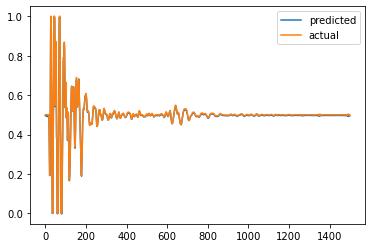

In [22]:
plt.plot(predicted[0].flatten(),label = "predicted")
plt.plot(X[0],label = "actual")
plt.legend()
plt.show()